In [46]:
import sys, os
from icecube import icetray, dataclasses, dataio
from I3Tray import I3Tray
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random 

gcdFile = dataio.I3File('/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_2020.Run134142.Pass2_V0.i3.gz')
frame = gcdFile.pop_frame()

while not frame.Has('I3Geometry'):
    frame = gcdFile.pop_frame()
geometry = frame.Get('I3Geometry')
om_geometry = geometry.omgeo

dom_x_positions=np.zeros((87,67))
dom_y_positions=np.zeros((87,67))
dom_z_positions=np.zeros((87,67))

for om, geo_info in om_geometry:
    dom_x_positions[om[0],om[1]]=geo_info.position.x
    dom_y_positions[om[0],om[1]]=geo_info.position.y
    dom_z_positions[om[0],om[1]]=geo_info.position.z
    
#places the selected string numbers of x, y, z positions into a new array
gen2_dom_x_positions = np.concatenate((dom_x_positions[1:6:2], dom_x_positions[14:21:2], dom_x_positions[31:40:2], dom_x_positions[51:60:2], dom_x_positions[68:75:2]))
gen2_dom_y_positions = np.concatenate((dom_y_positions[1:6:2], dom_y_positions[14:21:2], dom_y_positions[31:40:2], dom_y_positions[51:60:2], dom_y_positions[68:75:2]))
gen2_dom_z_positions = np.concatenate((dom_z_positions[1:6:2], dom_z_positions[14:21:2], dom_z_positions[31:40:2], dom_z_positions[51:60:2], dom_z_positions[68:75:2]))


In [47]:
def IC_bounds():
    x31_x75 = np.array([dom_x_positions[31][1],dom_x_positions[75][1]])
    y31_y75 = np.array([dom_y_positions[31][1],dom_y_positions[75][1]])
    
    x75_x78 = np.array([dom_x_positions[75][1],dom_x_positions[78][1]])
    y75_y78 = np.array([dom_y_positions[75][1],dom_y_positions[78][1]])
    
    x78_x72 = np.array([dom_x_positions[78][1],dom_x_positions[72][1]])
    y78_y72 = np.array([dom_y_positions[78][1],dom_y_positions[72][1]])
    
    x72_x74 = np.array([dom_x_positions[72][1],dom_x_positions[74][1]])
    y72_y74 = np.array([dom_y_positions[72][1],dom_y_positions[74][1]])
    
    x74_x50 = np.array([dom_x_positions[74][1],dom_x_positions[50][1]])
    y74_y50 = np.array([dom_y_positions[74][1],dom_y_positions[50][1]])
    
    x50_x6 = np.array([dom_x_positions[50][1],dom_x_positions[6][1]])
    y50_y6 = np.array([dom_y_positions[50][1],dom_y_positions[6][1]])
    
    x6_x1 = np.array([dom_x_positions[6][1],dom_x_positions[1][1]])
    y6_y1 = np.array([dom_y_positions[6][1],dom_y_positions[1][1]])
    
    x1_x31 = np.array([dom_x_positions[1][1],dom_x_positions[31][1]])
    y1_y31 = np.array([dom_y_positions[1][1],dom_y_positions[31][1]])
    
    plt.plot(x31_x75, y31_y75, color='red')
    plt.plot(x75_x78, y75_y78, color='red')
    plt.plot(x78_x72, y78_y72, color='red')
    plt.plot(x72_x74, y72_y74, color='red')
    plt.plot(x74_x50, y74_y50, color='red')
    plt.plot(x50_x6, y50_y6, color='red')
    plt.plot(x6_x1, y6_y1, color='red')
    plt.plot(x1_x31, y1_y31, color='red')
    

In [4]:
#off of wikipedia
def halton(b):
    #Generator function for Halton sequence.
    n, d = 0, 1
    while True:
        x = d - n
        if x == 1:
            n = 1
            d *= b
        else:
            y = d // b
            while x <= y:
                y //= b
            n = (b + 1) * y - x
        return n / d

In [5]:
halton(5)
#print(x)

0.2

In [22]:
#from tupui/halton.py on github

import numpy as np


def primes_from_2_to(n):
    """Prime number from 2 to n.
    From `StackOverflow <https://stackoverflow.com/questions/2068372>`_.
    :param int n: sup bound with ``n >= 6``.
    :return: primes in 2 <= p < n.
    :rtype: list
    """
    sieve = np.ones(n // 3 + (n % 6 == 2), dtype=np.bool)
    for i in range(1, int(n ** 0.5) // 3 + 1):
        if sieve[i]:
            k = 3 * i + 1 | 1
            sieve[k * k // 3::2 * k] = False
            sieve[k * (k - 2 * (i & 1) + 4) // 3::2 * k] = False
    return np.r_[2, 3, ((3 * np.nonzero(sieve)[0][1:] + 1) | 1)]


def van_der_corput(n_sample, base=2):
    """Van der Corput sequence.
    :param int n_sample: number of element of the sequence.
    :param int base: base of the sequence.
    :return: sequence of Van der Corput.
    :rtype: list (n_samples,)
    """
    sequence = []
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence


def halton(dim, n_sample):
    """Halton sequence.
    :param int dim: dimension
    :param int n_sample: number of samples.
    :return: sequence of Halton.
    :rtype: array_like (n_samples, n_features)
    """
    big_number = 10
    while 'Not enought primes':
        base = primes_from_2_to(big_number)[:dim]
        if len(base) == dim:
            break
        big_number += 1000

    # Generate a sample using a Van der Corput sequence per dimension.
    sample = [van_der_corput(n_sample + 1, dim) for dim in base]
    sample = np.stack(sample, axis=-1)[1:]

    return sample


print(van_der_corput(10))
# [0.0, 0.5, 0.25, 0.75, 0.125, 0.625, 0.375, 0.875, 0.0625, 0.5625]
print(halton(2, 21))
print(len(halton(67,21)[1]))
print(type(halton(2,21)[1]))

[0.0, 0.5, 0.25, 0.75, 0.125, 0.625, 0.375, 0.875, 0.0625, 0.5625]
[[0.5        0.33333333]
 [0.25       0.66666667]
 [0.75       0.11111111]
 [0.125      0.44444444]
 [0.625      0.77777778]
 [0.375      0.22222222]
 [0.875      0.55555556]
 [0.0625     0.88888889]
 [0.5625     0.03703704]
 [0.3125     0.37037037]
 [0.8125     0.7037037 ]
 [0.1875     0.14814815]
 [0.6875     0.48148148]
 [0.4375     0.81481481]
 [0.9375     0.25925926]
 [0.03125    0.59259259]
 [0.53125    0.92592593]
 [0.28125    0.07407407]
 [0.78125    0.40740741]
 [0.15625    0.74074074]
 [0.65625    0.18518519]]
67
<class 'numpy.ndarray'>


In [42]:
coords = halton(2,21)
x, y = coords.T
print(x)
print(y)

[0.5     0.25    0.75    0.125   0.625   0.375   0.875   0.0625  0.5625
 0.3125  0.8125  0.1875  0.6875  0.4375  0.9375  0.03125 0.53125 0.28125
 0.78125 0.15625 0.65625]
[0.33333333 0.66666667 0.11111111 0.44444444 0.77777778 0.22222222
 0.55555556 0.88888889 0.03703704 0.37037037 0.7037037  0.14814815
 0.48148148 0.81481481 0.25925926 0.59259259 0.92592593 0.07407407
 0.40740741 0.74074074 0.18518519]


In [43]:
x = 575*x
y = 575*y

print(x)
print(y)

[287.5     143.75    431.25     71.875   359.375   215.625   503.125
  35.9375  323.4375  179.6875  467.1875  107.8125  395.3125  251.5625
 539.0625   17.96875 305.46875 161.71875 449.21875  89.84375 377.34375]
[191.66666667 383.33333333  63.88888889 255.55555556 447.22222222
 127.77777778 319.44444444 511.11111111  21.2962963  212.96296296
 404.62962963  85.18518519 276.85185185 468.51851852 149.07407407
 340.74074074 532.40740741  42.59259259 234.25925926 425.92592593
 106.48148148]


In [48]:
"""  x: choosen x cooordinates
     y: choosen y coordinates
     random_gen: random number generator used to create x,y coordinates
"""
def plot_2d_icetop(x, y, random_gen):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('X-axis (m)')
    ax.set_ylabel('Y-axis (m)')
    ax.set_title("2D Gen2 Randomized Geometry with IceTop \n" + random_gen)
    IC_bounds()
    ax.scatter(x, y, s =9, c='blue')
    return fig
    

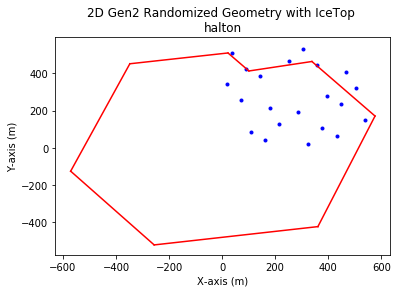

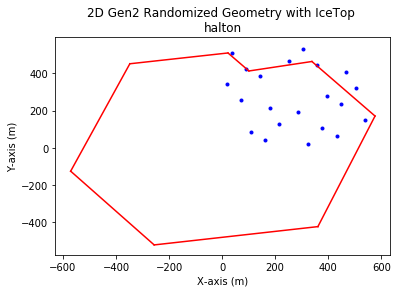

In [49]:
plot_2d_icetop(x,y, "halton")